# Model Configuration - 42 School Pass/Fail Prediction






In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import requests
import json
import csv
import warnings
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
warnings.filterwarnings(action='ignore')

## 0. Collecting data and Merge Data

### 0-1. Calling API

Please refer to the "Calling API Repository"

By calling /v2/campus/:/campus_id/users, we could separately collect raw data for all users of Seoul 42 Campus and Ecole 42 Campus, and the campus_ids for each are 29 and 1.

By calling /v2/users/:user_id/scale_teams/as_corrector and /v2/users/:user_id/scale_teams/as_corrected, 
we were able to obtain data in json format with items for events in which a user participated as a correcter and correction recipient.

By counting item named with corrcected, we've figured out how many evaluations they gave (corrector) and feedback they received(corrected).

### 0-2. Crawling

Please refer to the "Crawling Repository"

We collected 'PASS, Highest C Piscine, Final exam score, Number of group assignments, level, penalty' 

Data is collected through crawling by accessing each user's page.

Level: Overall progress that can be made through assignments, and midterm exams

Group Assignments: Optional group assignments

Penalty: How many times you cheated; each time a user get caught, 42 points will be deducted from assignment score

Highest C-picsine: In assignments using the C language, the highest level of assignment completed (0~13)

Final Exam Score: as it is.

## 1. Preprocessing
### 1-1. Load the data

In [24]:
data = pd.read_csv('/Users/kimkangmin/data_set_42seoul.csv')
data

,correcteds,correctors,created_at,PASS,Highest C Piscine,Final exam score,Number of group assignments,level,penalty
0,2,6,10,0,0,NaN,0,0.00,0
1,14,0,10,0,0,NaN,0,0.00,0
2,2,7,10,0,0,NaN,1,1.19,0
3,40,26,10,0,4,NaN,3,5.34,0
4,0,0,10,0,0,NaN,0,0.00,0
...,...,...,...,...,...,...,...,...,...
4318,92,96,2,1,11,66.0,3,9.84,0
4319,56,66,2,1,9,66.0,4,7.92,0
4320,67,80,2,1,9,54.0,3,8.85,0
4321,103,120,2,1,11,100.0,4,12.94,0


### 1-2. drop the data points whose final exam score is under 42.

In [25]:
data = data[data['Final exam score'] >= 42]
data.shape

(2911, 9)

### 1-3. checking the VIF

In [26]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

In [27]:
features_for_vif = data.drop('PASS', axis=1).select_dtypes(include=['float', 'int'])

# Calculate VIF
vif_result = calculate_vif(features_for_vif)

# Display VIF results
print("VIF Results:")
print(vif_result)

VIF Results:
                       Feature        VIF
0                   correcteds  22.603433
1                   correctors  29.333567
2                   created_at   8.581801
3            Highest C Piscine  49.141438
4             Final exam score  36.154867
5  Number of group assignments  14.160705
6                        level  59.255415
7                      penalty   1.008364


### Dropping 'level'

There is high VIF in the 'level'.

1. Redundancy:
The 'level' feature is a sum of assignments and tests.
Including both the individual assignments/tests and their sum ('level') in the model may introduce redundancy.

2. Interpretability:
one of the primary goal is to understand the impact of individual assignments and tests on the outcome.
So, having both the components and the sum might complicate the interpretation of the model.

For the following reasons, we decided to remove the level attribute.

In [28]:
data = data.drop('level', axis=1)

features_for_vif = features_for_vif = data.drop('PASS', axis=1)

# Calculate VIF
vif_result = calculate_vif(features_for_vif)

# Display VIF results
print("VIF Results:")
print(vif_result)

VIF Results:
                       Feature        VIF
0                   correcteds  22.585018
1                   correctors  29.244980
2                   created_at   7.986267
3            Highest C Piscine  34.297863
4             Final exam score  29.453979
5  Number of group assignments  14.150442
6                      penalty   1.007189


### Reforming 'correcteds and correctors'

There is high VIF in the 'correcteds and correctors'.
Since this is predicted to be highly correlated, and our goal is to determine whether peer review is important, we will create a new column called peer review by combining 'correcteds and correctors'.

In [29]:
data['peer_reviews'] = data['correcteds'] + data['correctors']

data = data.drop(['correcteds', 'correctors'], axis=1)

features_for_vif = features_for_vif = data.drop('PASS', axis=1)

# Calculate VIF
vif_result = calculate_vif(features_for_vif)

# Display VIF results
print("VIF Results:")
print(vif_result)

VIF Results:
                       Feature        VIF
0                   created_at   7.957928
1            Highest C Piscine  34.224611
2             Final exam score  29.132751
3  Number of group assignments  14.148936
4                      penalty   1.006670
5                 peer_reviews   7.237190


### Although High VIFs...
Other features also show quite large VIFs. This is because participants who show sincerity and excellence in one field also show sincerity and excellence in other fields. However, because our goal was to confirm the importance of variables, we decided to train the model without removing additional variables.

Instead, it was decided to exclude logistic regression, which showed weakness in coefficient results under high VIF, from the model candidates.

### 1-3. EDA

### Pair Plot

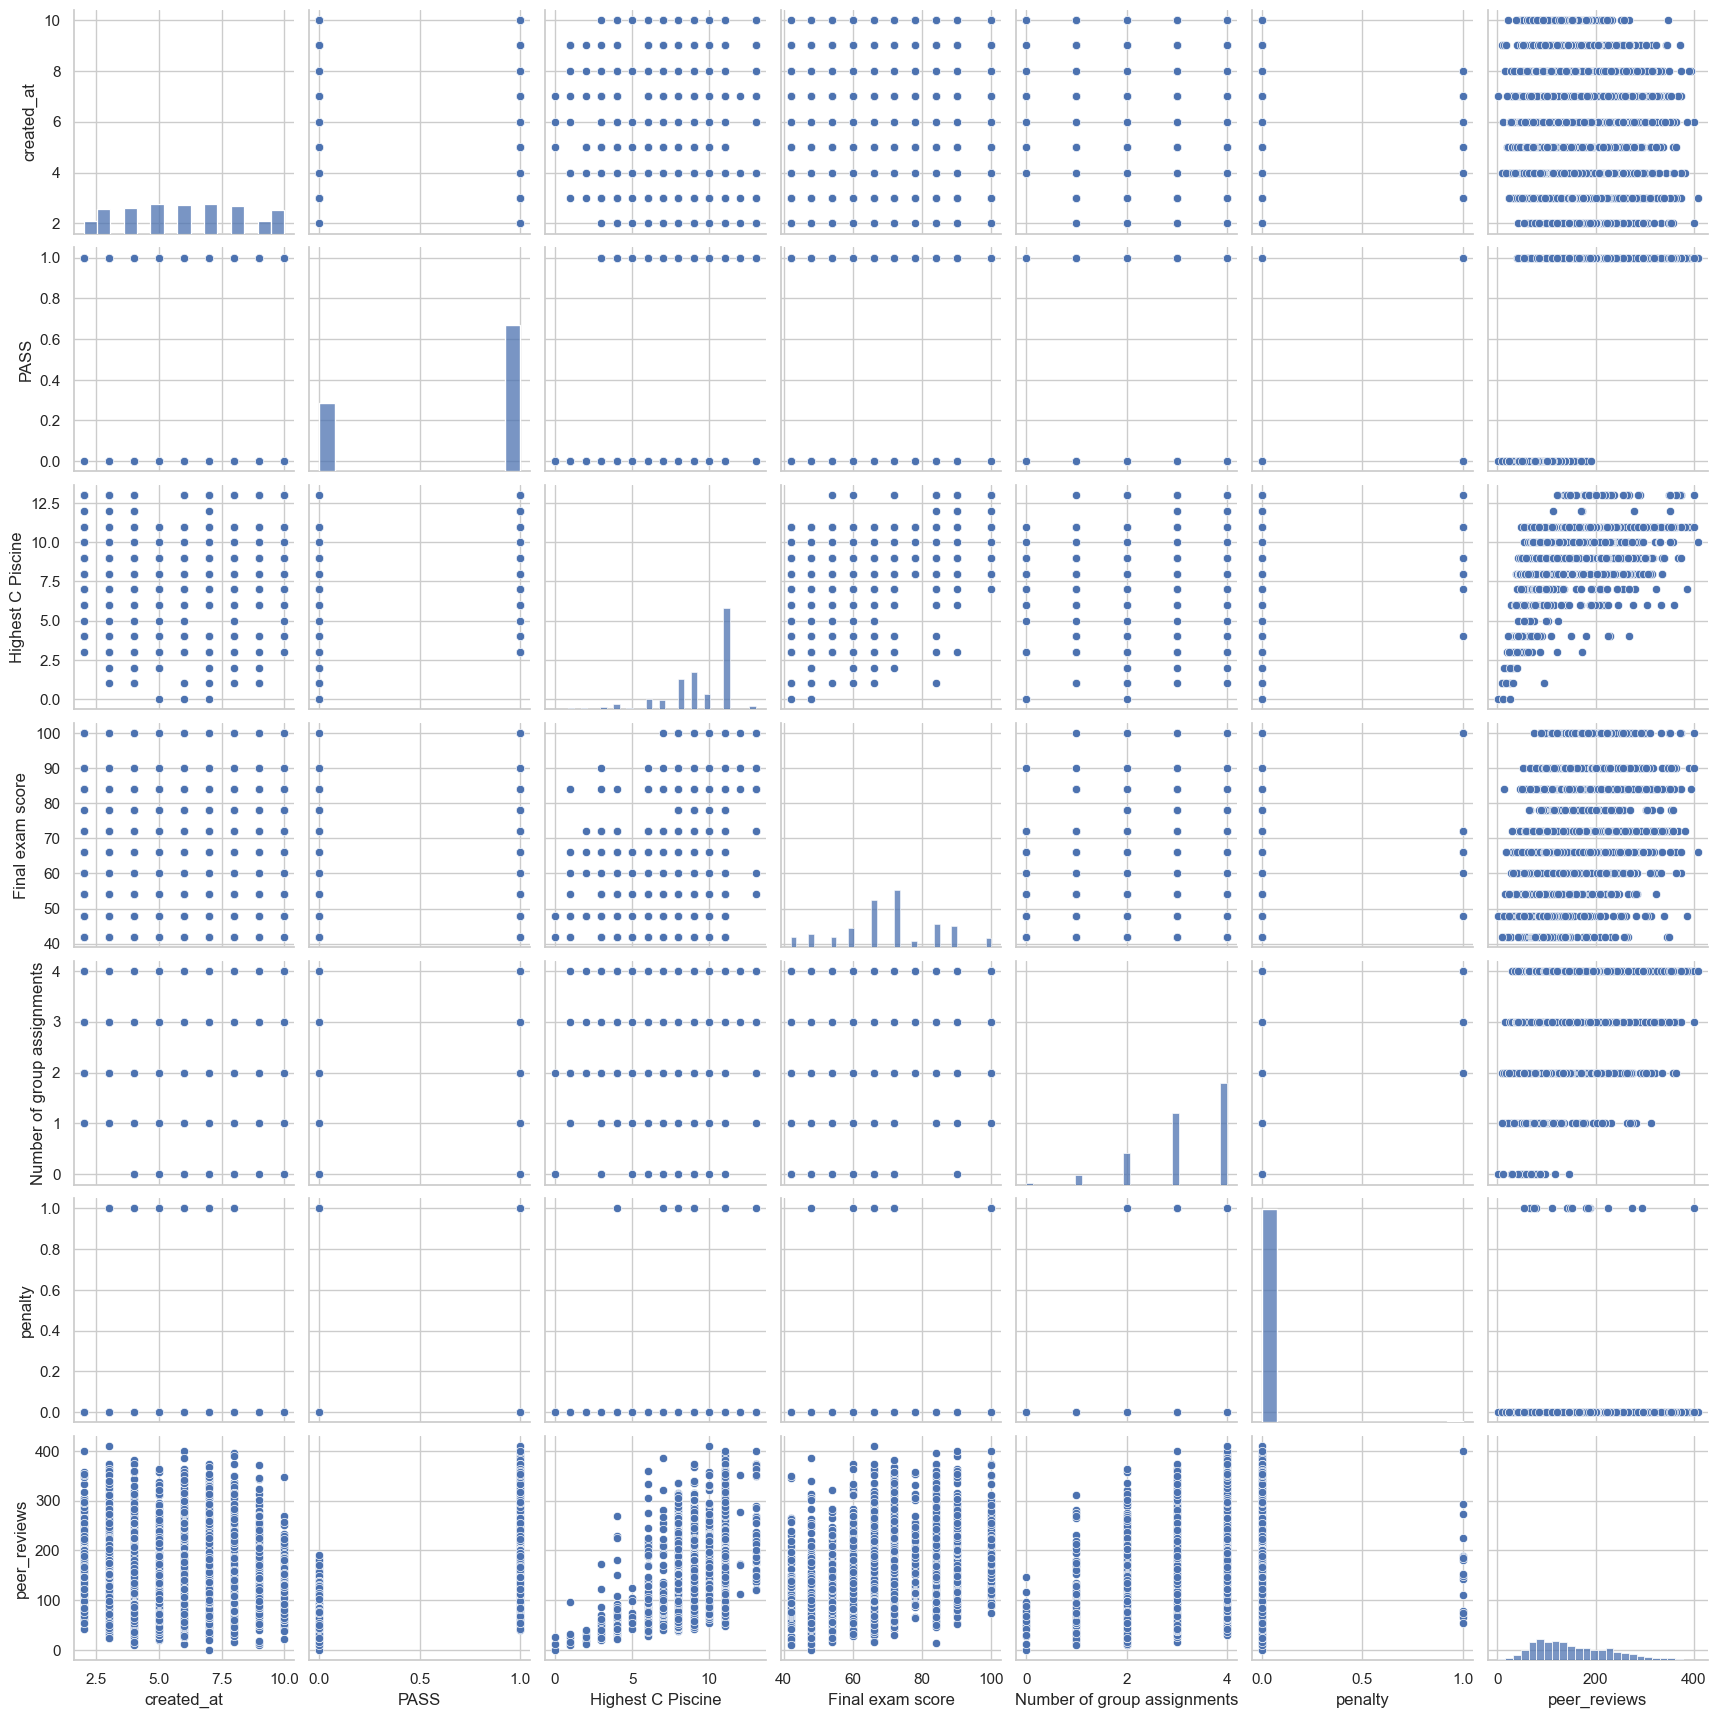

In [30]:
import seaborn as sns
sns.pairplot(data)
plt.show()

### Get Statistics value

In [31]:
from scipy.stats import mode
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
from statistics import StatisticsError

summary_data = pd.DataFrame()

for column in data.columns:
    if column in ['PASS', 'created_at']:
        continue
    values = data[column].values
    try:
        mode_value = mode(values)
    except StatisticsError:
        mode_value = "No unique mode" if len(set(values)) > 1 else np.nan
   

    summary_data[column] = [
        np.mean(values),
        np.median(values),
        mode_value,
        np.std(values),
        np.min(values),
        np.max(values)
    ]

summary_data.index = ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Minimum', 'Maximum']


# Convert DataFrame to HTML table
html_table = summary_data.to_html()

# Display the HTML table
display(HTML(html_table))


,Highest C Piscine,Final exam score,Number of group assignments,penalty,peer_reviews
Mean,9.482308,70.219856,3.216077,0.005496,153.853659
Median,10.0,72.0,3.0,0.0,139.0
Mode,"([11], [1369])","([72.0], [777])","([4], [1372])","([0], [2895])","([123], [28])"
Standard Deviation,2.007444,13.777185,0.902511,0.073934,75.26107
Minimum,0,42.0,0,0,1
Maximum,13,100.0,4,1,409


### Box Plot

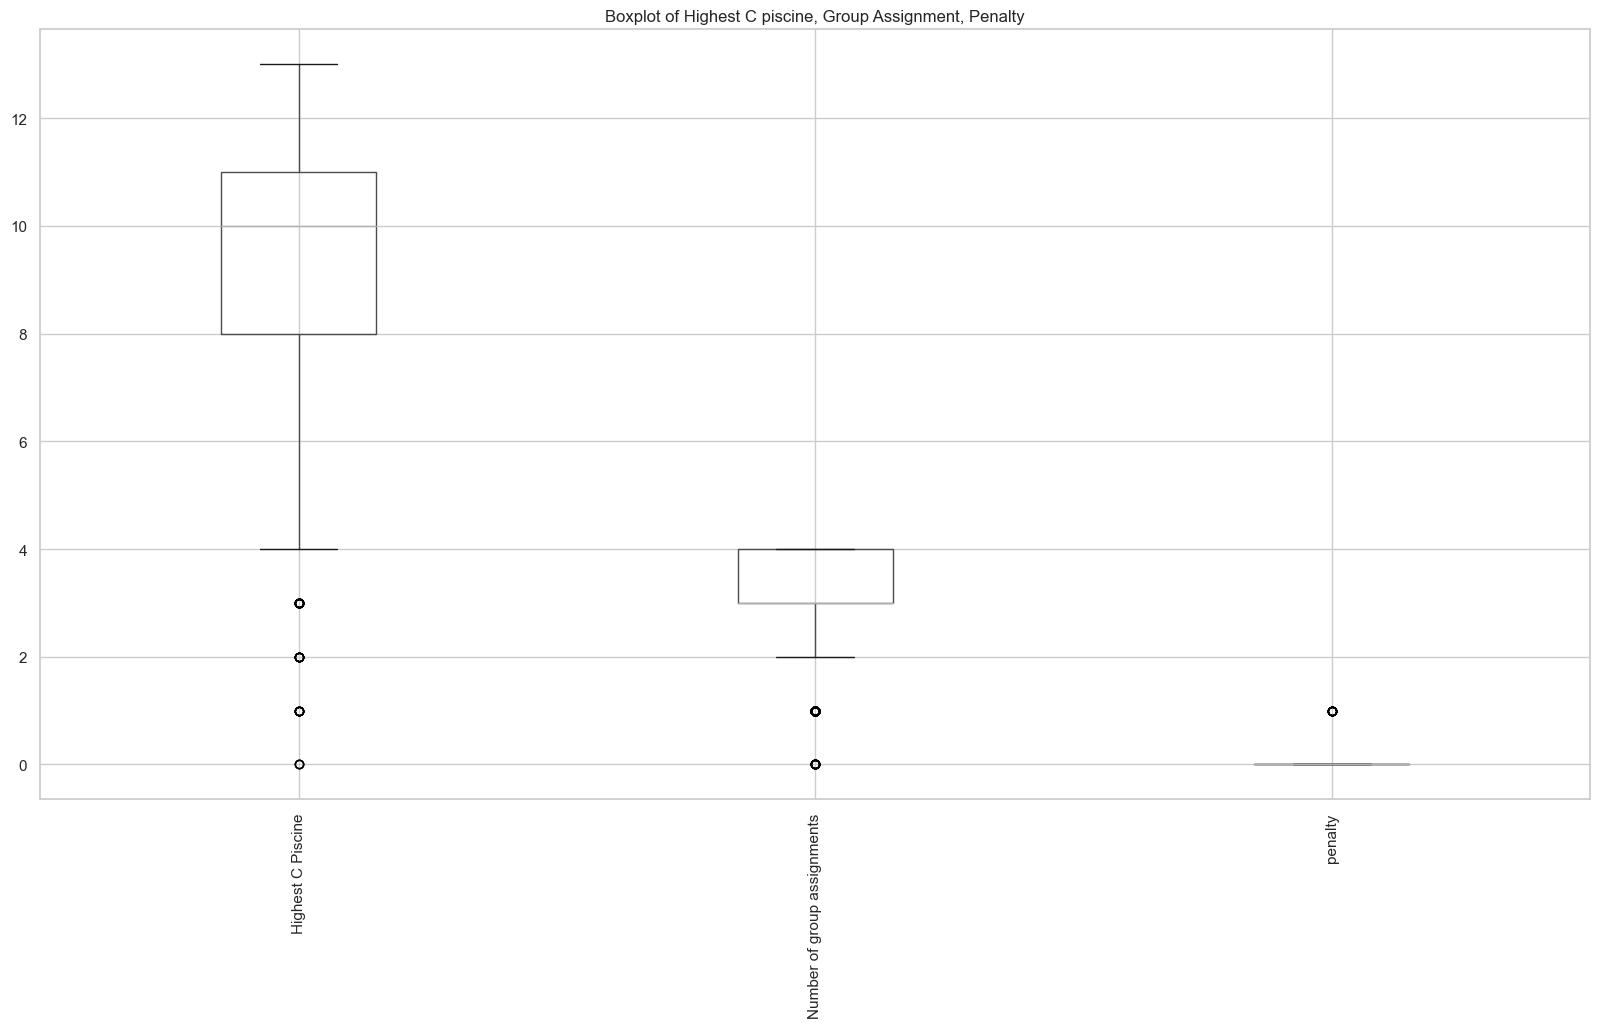

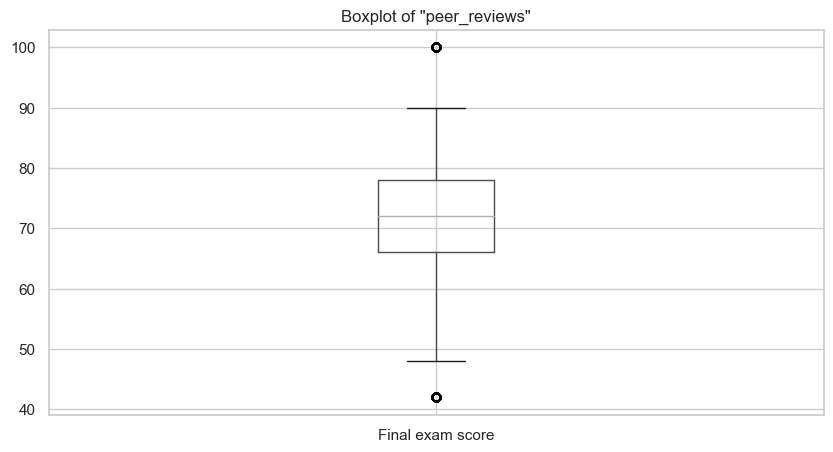

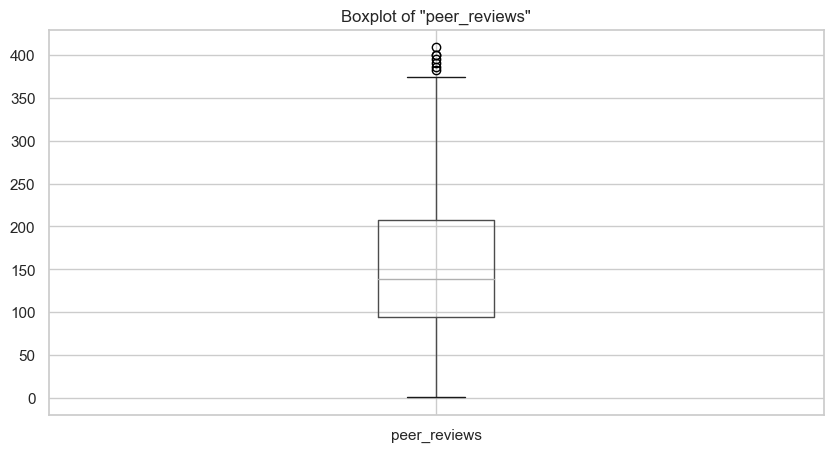

In [37]:
import matplotlib.pyplot as plt

data_copy = data.drop(['PASS', 'created_at'], axis=1)

# Select only numeric columns
numeric_columns = data_copy.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('peer_reviews')
numeric_columns.remove('Final exam score')

plt.figure(figsize=(20,10))
data_copy.boxplot(column=numeric_columns)
plt.xticks(rotation=90) # Rotate labels for better visibility
plt.title('Boxplot of Highest C piscine, Group Assignment, Penalty')
plt.show()

plt.figure(figsize=(10,5))
data_copy.boxplot(column='Final exam score')
plt.title('Boxplot of "peer_reviews"')
plt.show()

plt.figure(figsize=(10,5))
data_copy.boxplot(column='peer_reviews')
plt.title('Boxplot of "peer_reviews"')
plt.show()


### Correlation Matrix

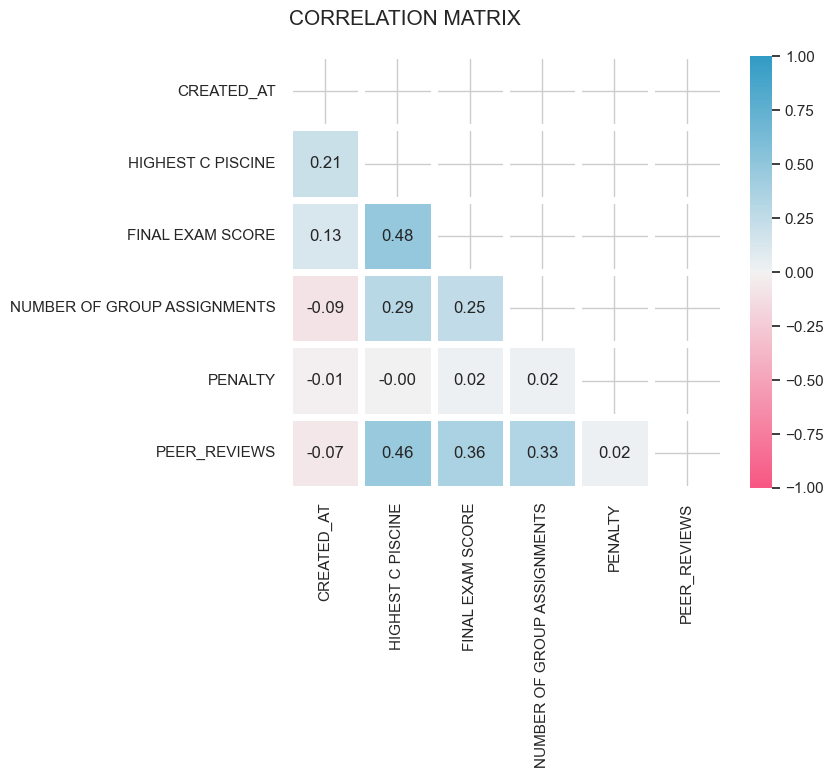

In [39]:
data_for_corr = data.drop(columns=['PASS'])

# Create a correlation matrix
corr = data_for_corr.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(7, 7))

# Create a diverging colormap
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

# Plot the heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
            linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
            cbar_kws={"shrink": .8}, square=True)

# Set yticks and xticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

# Set the title
title = 'CORRELATION MATRIX\n'
plt.title(title, loc='left', fontsize=15)

# Show the plot
plt.show()

### Pie chart for Pass/Fail distribution

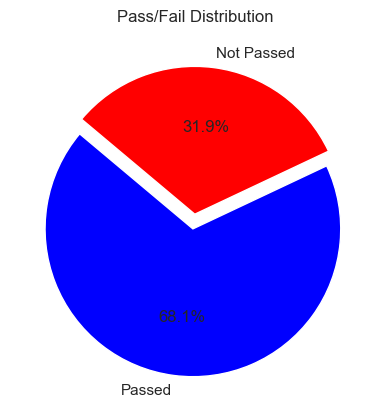

In [38]:
# Count the number of 'passed' and 'not passed'
passed_counts = data['PASS'].value_counts()

# Pie chart
labels = ['Passed', 'Not Passed']
colors = ['blue', 'red']
explode = (0.1, 0)  # Explode the 'Passed' slice for emphasis

plt.pie(passed_counts, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140)

# Add title
plt.title('Pass/Fail Distribution')

# Show the plot
plt.show()

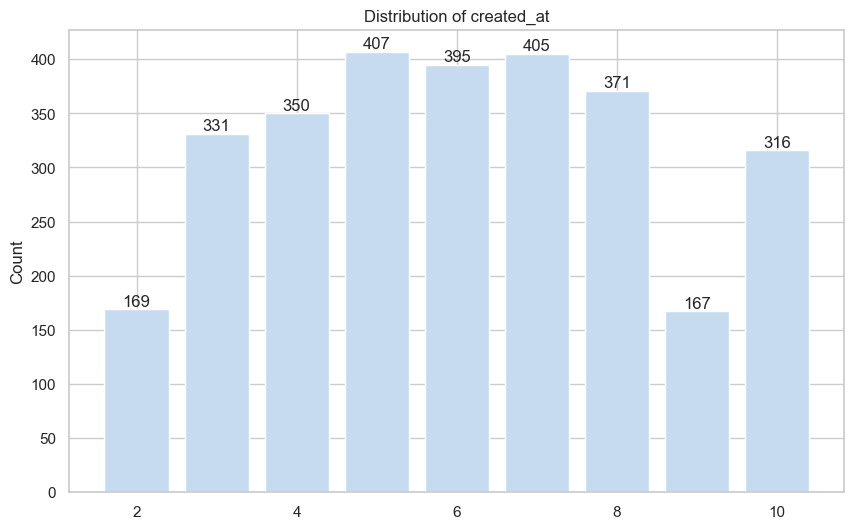

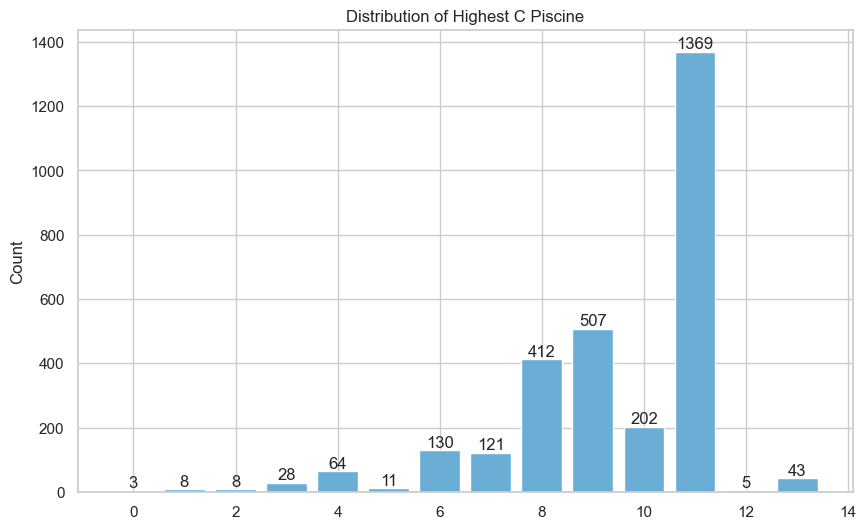

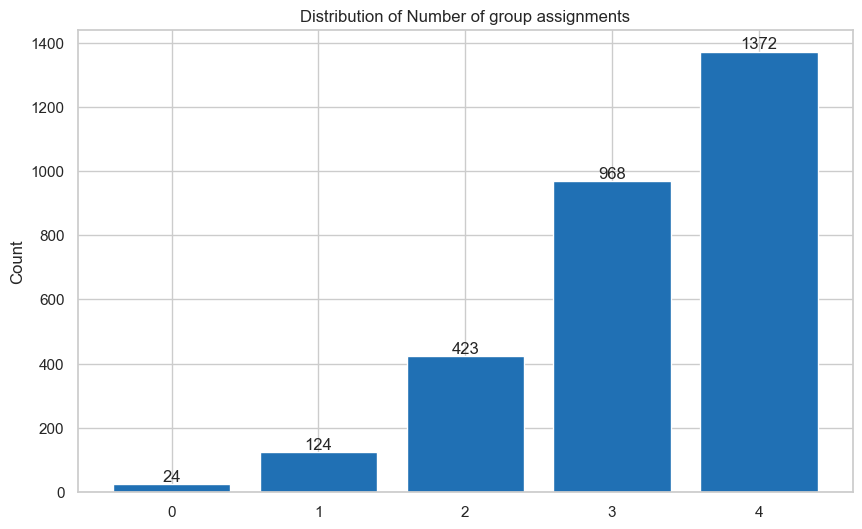

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

attributes = ['created_at', 'Highest C Piscine', 'Number of group assignments']
color_palette = sns.color_palette("Blues", n_colors=len(attributes))

# Create separate bar charts for each attribute
for i, attribute in enumerate(attributes):
    # Group by attribute and count occurrences
    grouped_data = data.groupby(attribute).size().reset_index(name='Count')

    color = color_palette[i]

    # create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(grouped_data[attribute], grouped_data['Count'], color=color)

    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {attribute}')


    for bar, label in zip(bars, grouped_data['Count']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, label, ha='center', va='bottom')

    plt.show()


### Bubble Chart for Peer Reviews and Result of the Exam

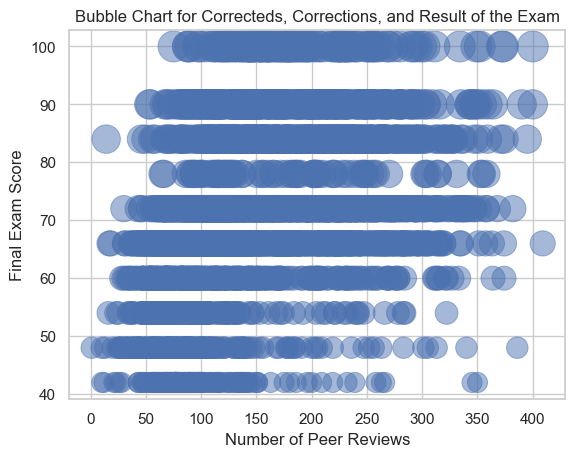

In [14]:
plt.scatter(data['peer_reviews'], data['Final exam score'], s=data['Final exam score']*5, alpha=0.5, edgecolors="b", linewidth=0.7)

# Add labels and title
plt.xlabel('Number of Peer Reviews')
plt.ylabel('Final Exam Score')
plt.title('Bubble Chart for Peer Reviews and Result of Final Exam')

# Show the plot
plt.show()

### Highest C-Piscine and Passed Ratio

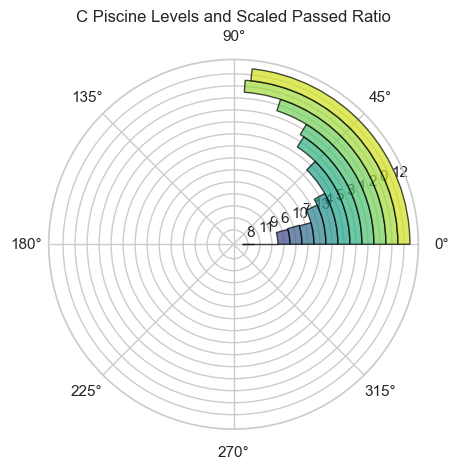

In [15]:
ratio_passed = data.groupby('Highest C Piscine')['PASS'].mean()

ratio_passed_scaled = ((ratio_passed - ratio_passed.min()) / (ratio_passed.max() - ratio_passed.min()))*1.5

num_circles = len(ratio_passed_scaled)

theta = np.linspace(0, 2 * np.pi, num_circles, endpoint=False)

ratio_passed_scaled = np.concatenate((ratio_passed_scaled, [ratio_passed_scaled.iloc[0]]))
theta = np.concatenate((theta, [theta[0]]))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

colors = plt.cm.viridis(np.linspace(0, 1, len(ratio_passed_scaled)))

bars = ax.barh(theta, ratio_passed_scaled, height=2 * np.pi / num_circles, alpha=0.7, color=colors, edgecolor='black')

ax.set_yticks(theta[:-1])
ax.set_yticklabels(data['Highest C Piscine'].unique())

ax.set_title('C Piscine Levels and Scaled Passed Ratio')

plt.show()

### 1-4. Apply one-hot encoding for splitting generation

In [16]:
data_encoded = pd.get_dummies(data['created_at'].astype(str), prefix='generation')

data = pd.concat([data, data_encoded], axis=1)

data = data.drop('created_at', axis=1)

data

,PASS,Highest C Piscine,Final exam score,Number of group assignments,penalty,peer_reviews,generation_10,generation_2,generation_3,generation_4,generation_5,generation_6,generation_7,generation_8,generation_9
5,0,8,54.0,0,0,146,1,0,0,0,0,0,0,0,0
6,1,11,72.0,3,0,219,1,0,0,0,0,0,0,0,0
8,0,9,60.0,3,0,122,1,0,0,0,0,0,0,0,0
13,0,6,60.0,4,0,73,1,0,0,0,0,0,0,0,0
18,1,11,66.0,3,0,170,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4318,1,11,66.0,3,0,188,0,1,0,0,0,0,0,0,0
4319,1,9,66.0,4,0,122,0,1,0,0,0,0,0,0,0
4320,1,9,54.0,3,0,147,0,1,0,0,0,0,0,0,0
4321,1,11,100.0,4,0,223,0,1,0,0,0,0,0,0,0


## 2. Data Mining

### 2-1. Split the data into train set and test set

In [17]:
X = data.drop('PASS', axis = 1)
y = data['PASS']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

### 2-2. Piepelining

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Define the pipeline with imbalanced-learn
pipe = ImbPipeline([
    ('preprocessing', None),
    ('sampler', None),  # Added for oversampling/undersampling
    ('classifier', None)
])
hyperparam_grid = [
    {
        'preprocessing': [None],
        'classifier': [RandomForestClassifier()],
        'classifier__max_features': [1, 2, 3, 4, 5],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30],
        'sampler': [RandomOverSampler(), RandomUnderSampler(), None]
    },{
        'preprocessing': [StandardScaler(), MinMaxScaler(), None],
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [1, 3, 5, 10, 15],
        'classifier__metric': ['minkowski', 'euclidean', 'mahalanobis'],
        'sampler': [RandomOverSampler(), RandomUnderSampler(), None]
    }
]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(pipe, hyperparam_grid, scoring='roc_auc', refit=True, cv=kfold)
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best Training score: {grid_search.best_score_}")
print(f"Test-set score: {grid_search.score(X_test, y_test)}")

Best hyperparameters: {'classifier': RandomForestClassifier(criterion='entropy', max_depth=10, max_features=3,
                       n_estimators=300), 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 3, 'classifier__n_estimators': 300, 'preprocessing': None, 'sampler': RandomUnderSampler()}
Best Training score: 0.9712478340089788
Test-set score: 0.9813202818046336


## 3. Post-Processing

### 3-1. ROC Curve

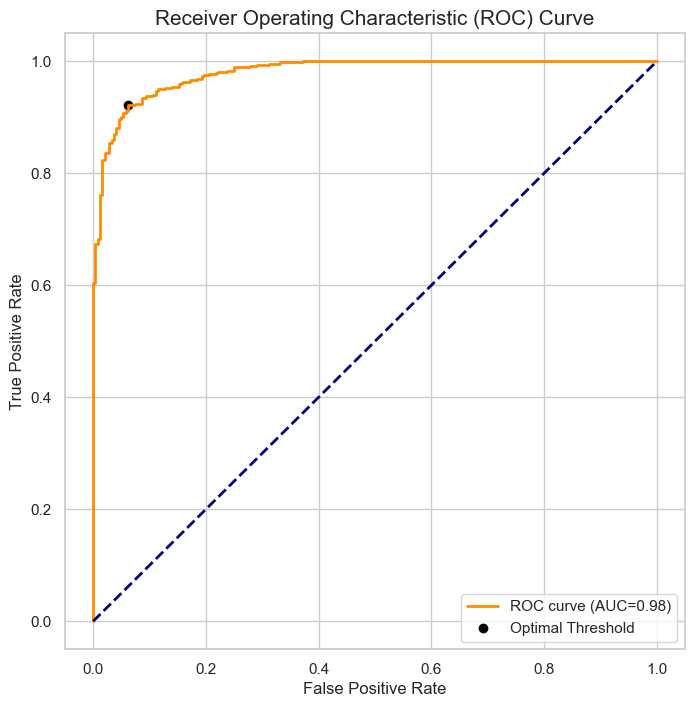

Optimal threshold value: 0.5248082182958851


In [47]:
from sklearn.metrics import roc_curve, auc

# Find the optimal model prediction probability
y_prob = grid_search.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Calculate the Youden's index and find the optimal threshold
youdens_index = tpr - fpr
optimal_idx = np.argmax(youdens_index)
optimal_threshold = thresholds[optimal_idx]

# Draw ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal Threshold')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc='lower right')
plt.show()

print(f"Optimal threshold value: {optimal_threshold}")

### 3-2. Confusion Matrix

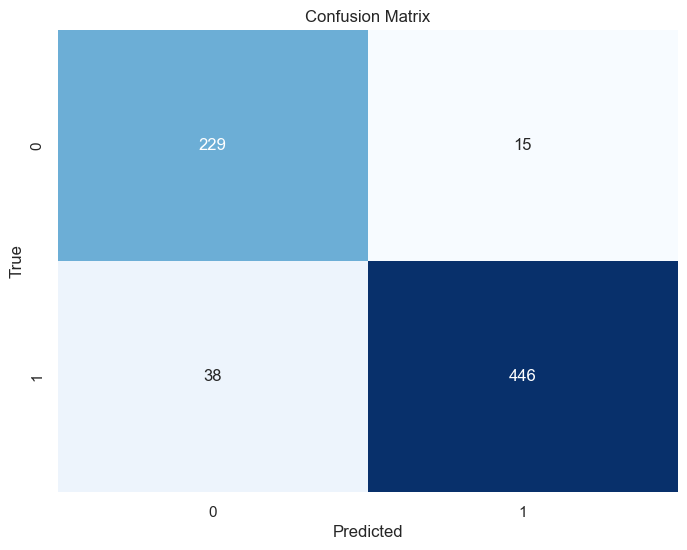

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Apply the optimal threshold
y_prob = grid_search.predict_proba(X_test)[:, 1]
y_pred_optimal = np.where(y_prob >= optimal_threshold, 1, 0)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 3-3. Evaluation Metrics

Accuracy: 0.9272
Precision: 0.9675
Recall: 0.9215
F1 Score: 0.9439


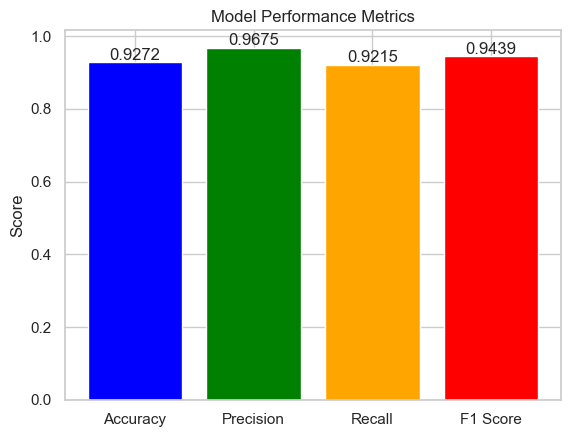

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualization
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['blue', 'green', 'orange', 'red'])

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()

Precision is currently very high, but recall is relatively low. This means that although the model is great at accurately predicting Positives, it tends to misclassify some Positive cases as Negatives.

Lowering the threshold lowers the criteria for determining that a model is positive, which increases recall, but may decrease precision. This is because the model will classify more samples as positive, thus increasing the number of false positives.

In problems where minimizing false negatives is important (e.g., cancer diagnosis), recall can be prioritized, but since our goal is more important than minimizing false positives, that threshold is appropriate.

### 3-4. Feature Importance

In [52]:
best_classifier = grid_search.best_estimator_.named_steps['classifier']

if isinstance(best_classifier, LogisticRegression):
    # For Logistic Regression, retrieve coefficients as feature importances
    coefficients = best_classifier.coef_[0]
    feature_importances = abs(coefficients)  # Use absolute values for importance
    feature_names = X_train.columns  # Assuming X_train is a DataFrame
    importance_dict = dict(zip(feature_names, feature_importances))
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    print("Feature Importances (Logistic Regression):")
    for feature, importance in sorted_importance:
        print(f"{feature}: {importance}")

elif isinstance(best_classifier, RandomForestClassifier) or isinstance(best_classifier, KNeighborsClassifier):
    # Fit the best model from grid search on the entire training data
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = best_model.named_steps['classifier'].feature_importances_

    # Create a DataFrame to display feature importances
    importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the feature importances
    print("Feature Importances:")
    print(importance_df)

Feature Importances:
                        Feature  Importance
4                  peer_reviews    0.526512
1              Final exam score    0.180480
0             Highest C Piscine    0.087572
2   Number of group assignments    0.049470
7                  generation_3    0.047783
6                  generation_2    0.021143
9                  generation_5    0.020450
13                 generation_9    0.016287
12                 generation_8    0.012307
5                 generation_10    0.011970
10                 generation_6    0.009311
11                 generation_7    0.008247
8                  generation_4    0.006615
3                       penalty    0.001854
